0. PREPROCESSING

- HISTOGRAM EQUALIZATION 

In [28]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os 
from typing import Tuple

In [29]:
def histogram_count_values(image: np.ndarray, nbins: int) -> np.ndarray:
    """Creates a histogram of a grayscale image."""
    size_x = image.shape[0]
    size_y = image.shape[1]
    hist = np.zeros(nbins) 
    for i in range(size_x):
        for j in range(size_y):
            value = image[i, j]
            discretized_value = int(value * (nbins-1) / 255)
            hist[discretized_value] += 1
    return hist

In [30]:
def windowing(image: np.ndarray, lower_threshold: float, upper_threshold: float) -> np.ndarray:
    """Linear normalization assigning values lower or equal to lower_threshold to 0, and values greater or equal to upper_threshold to 255."""
    out = (image - lower_threshold) / (upper_threshold - lower_threshold)
    out[out < 0] = 0
    out[out > 1] = 1
    return out*255


def minmax_normalization(image: np.ndarray) -> np.ndarray:
    """Linear normalization assigning the lowest value to 0 and the highest value to 255."""
    return windowing(image, np.min(image), np.max(image))

In [31]:
def histogram_equalization(image: np.ndarray) -> np.ndarray:
    """Histogram equalization."""
    hist = histogram_count_values(image, nbins=256)
    cumhist = np.cumsum(hist)
    mapping = minmax_normalization(cumhist)
    return mapping[image.astype('uint8')]

- CLAHE 

In [32]:
def clahe(image: np.ndarray, clip_limit=5.0, grid_size=(4, 4)) -> np.ndarray:
    """Contrast-limited adaptive histogram equalization."""
    image = image.astype('uint8')   
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    return clahe.apply(image)

In [33]:
files = os.listdir("./data/")
results ={}
for i,path in enumerate(files[:10]):
    img = cv2.imread(os.path.join("./data/",path), cv2.IMREAD_GRAYSCALE)  # Read the image.
    img = img.astype('float32')  # Convert to float32 to avoid overflow and rounding errors
    results[f'{path}']= {
        'img': img,
        'histogram_equalization': histogram_equalization(img),
        'clahe': clahe(img.astype('uint8'))
    }


In [34]:
first_key = next(iter(results))
print(first_key)
print(iter(results))

1660366800.jpg


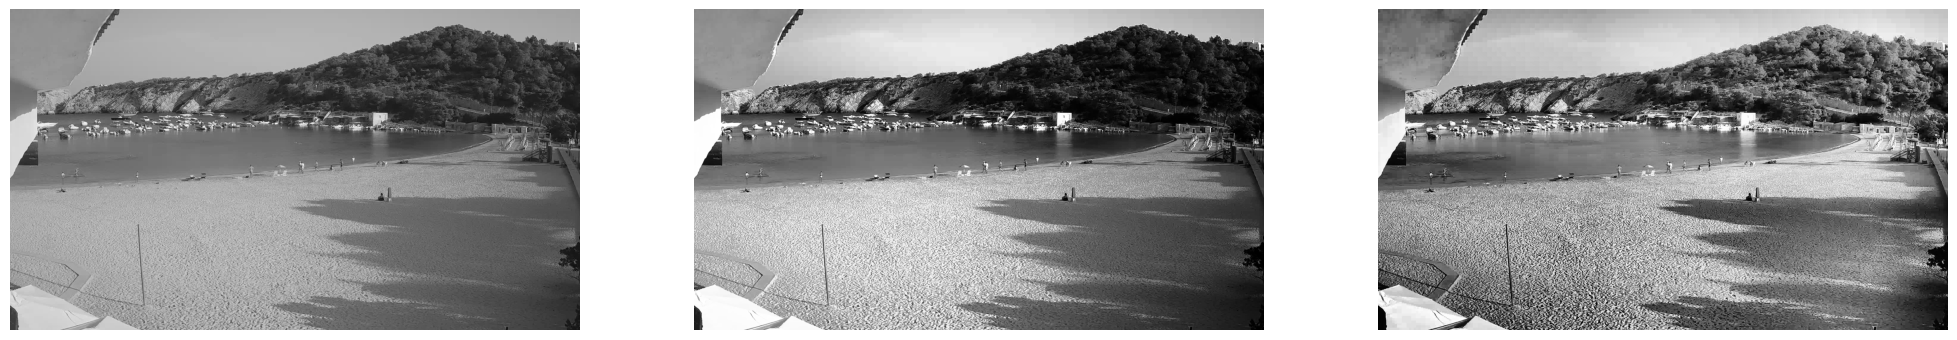

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))
axs[0].imshow(results['1660374000.jpg']['img'], cmap='gray')
axs[0].axis('off') 
axs[1].imshow(results['1660374000.jpg']['histogram_equalization'], cmap='gray')
axs[1].axis('off') 
axs[2].imshow(results['1660374000.jpg']['clahe'], cmap='gray')
axs[2].axis('off') 
plt.show()

1. IMAGE AVERAGING

Image Averaging involves stacking multiple photos taken from a fixed position with identical settings and using a software such as Photoshop to average the pixels and increase the information taken from each image to reduce noise and simulate longer shutter speeds.
https://tokinalens.com/reviews/introduction_to_image_averaging/ 

merge frist 2

In [36]:
def image_averaging(images, type):
    image_data = []
    for i in images:
        image_data.append(results[i][type])
    avg_image = image_data[0]
    for i in range(len(image_data)):
        if i == 0:
            pass
        else:
            alpha = 1.0/(i + 1)
            beta = 1.0 - alpha
            avg_image = cv2.addWeighted(image_data[i], alpha, avg_image, beta, 0.0)
    return avg_image        
    


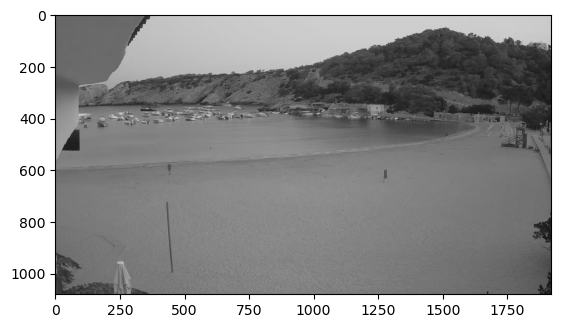

In [37]:
images=["1660366800.jpg","1660370400.jpg"]
avg_image = image_averaging(images, 'img')
cv2.imwrite('./data/avg_empty_beach2.png', avg_image)
avg_image = cv2.imread('./data/avg_empty_beach2.png')
plt.imshow(avg_image)
plt.show()

averaging HISTOGRAM EQUALIZATION

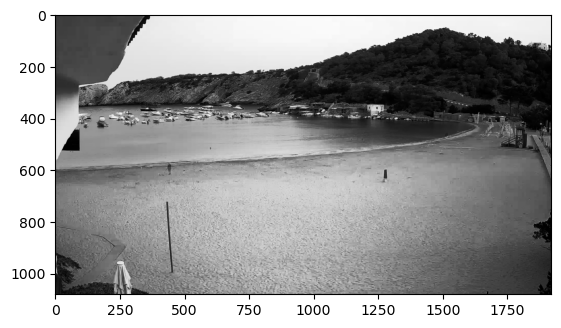

In [38]:
images=["1660366800.jpg","1660370400.jpg"]
avg_image = image_averaging(images, 'histogram_equalization')
cv2.imwrite('./data/avg_HE_beach2.png', avg_image)
avg_image = cv2.imread('./data/avg_HE_beach2.png')
plt.imshow(avg_image)
plt.show()

CLAHE AVERAGING

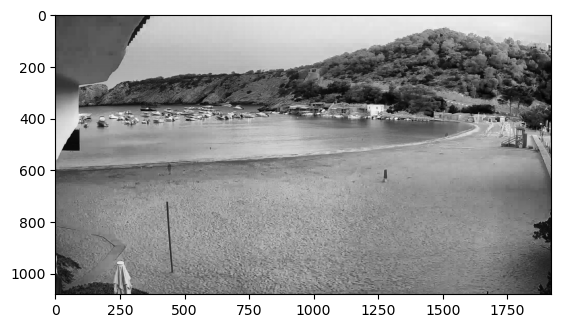

In [39]:
images=["1660366800.jpg","1660370400.jpg"]
avg_image = image_averaging(images, 'clahe')
cv2.imwrite('./data/avg_clahe_beach2.png', avg_image)
avg_image = cv2.imread('./data/avg_clahe_beach2.png')
plt.imshow(avg_image)
plt.show()

2. PIXEL-WISE COMPARISON

In [40]:
def pixel_wise(empty, crowded):
    empty_image = cv2.cvtColor(empty, cv2.COLOR_BGR2GRAY)
    empty_image = empty_image.astype(np.uint8)
    crowded_image = crowded.astype(np.uint8)
    # Pixel-wise subtraction
    difference = cv2.absdiff(crowded_image, empty_image)
    # Threshold the difference
    _, thresholded = cv2.threshold(difference, 45, 255, cv2.THRESH_BINARY)
    return thresholded


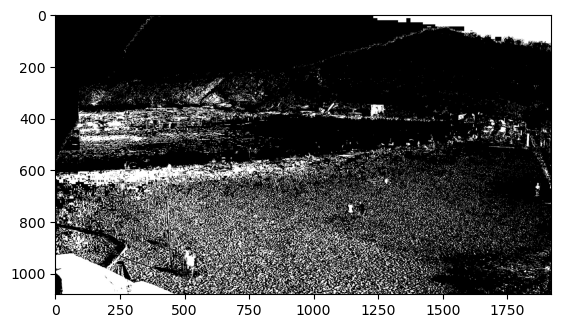

In [41]:
# Load images
empty_image = cv2.imread('./data/avg_empty_beach2.png')
crowded_image = results["1660377600.jpg"]['img']
thres = pixel_wise(empty_image, crowded_image)
cv2.imwrite('./data/difference_mask.jpg', thres)
avg_image = cv2.imread('./data/difference_mask.jpg')
plt.imshow(avg_image)
plt.show()


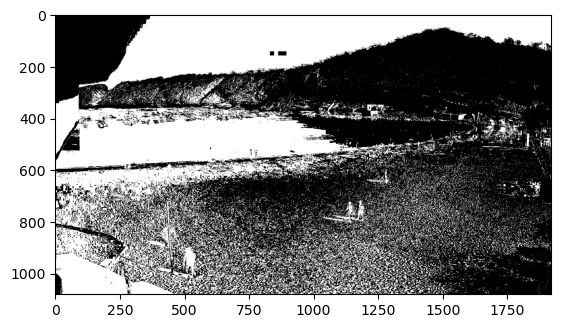

In [42]:
# Load images
empty_image = cv2.imread('./data/avg_HE_beach2.png')
crowded_image = results["1660377600.jpg"]['histogram_equalization']
thres = pixel_wise(empty_image, crowded_image)

cv2.imwrite('./data/difference_mask2.jpg', thres)
avg_image = cv2.imread('./data/difference_mask2.jpg')
plt.imshow(avg_image)
plt.show()


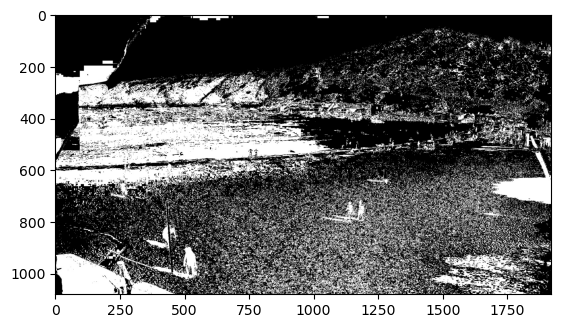

In [43]:
# Load images
empty_image = cv2.imread('./data/avg_clahe_beach2.png')
crowded_image = results["1660377600.jpg"]['clahe']
thres = pixel_wise(empty_image, crowded_image)
cv2.imwrite('./data/difference_mask3.jpg', thres)
avg_image = cv2.imread('./data/difference_mask3.jpg')
plt.imshow(avg_image)
plt.show()


3. APPLY THERSHOLDING 
noise reduction

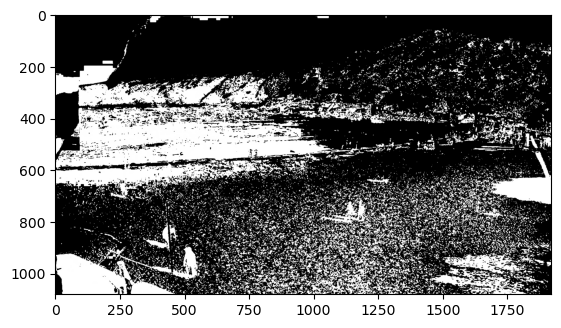

In [50]:
avg_image = cv2.imread('./data/difference_mask3.jpg')
gaussian_filter = cv2.GaussianBlur(avg_image,(3,3),0)
median_filter = cv2.medianBlur(avg_image,3)
plt.imshow(median_filter)
plt.show()

4. COUNTING 

- BLOB DETECTION 
- COUNT CONTOURS AND BOUNDING BOX 

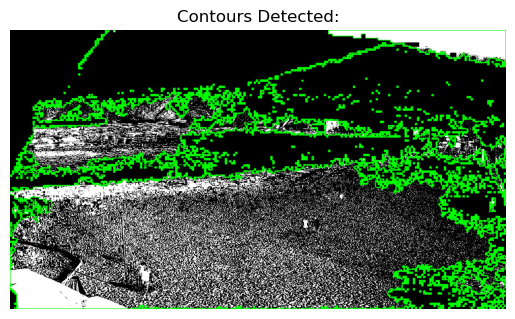

In [45]:
avg_image = cv2.imread('./data/difference_mask.jpg',cv2.IMREAD_GRAYSCALE)
contours, _ = cv2.findContours(avg_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = cv2.cvtColor(avg_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title(f"Contours Detected:")
plt.axis('off')
plt.show()

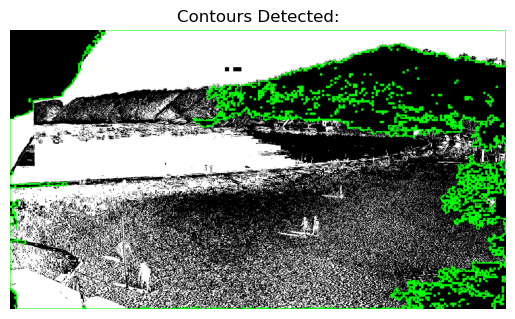

In [46]:
avg_image = cv2.imread('./data/difference_mask2.jpg',cv2.IMREAD_GRAYSCALE)
contours, _ = cv2.findContours(avg_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = cv2.cvtColor(avg_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title(f"Contours Detected:")
plt.axis('off')
plt.show()

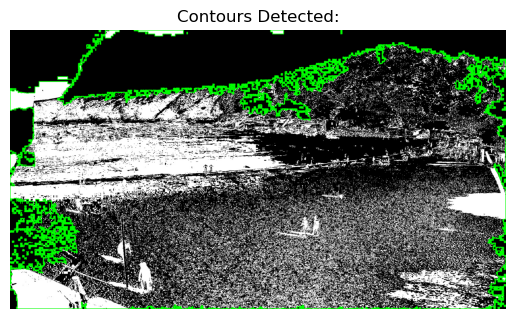

In [47]:
avg_image = cv2.imread('./data/difference_mask3.jpg',cv2.IMREAD_GRAYSCALE)
contours, _ = cv2.findContours(avg_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = cv2.cvtColor(avg_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title(f"Contours Detected:")
plt.axis('off')
plt.show()

find contours with noise reduction

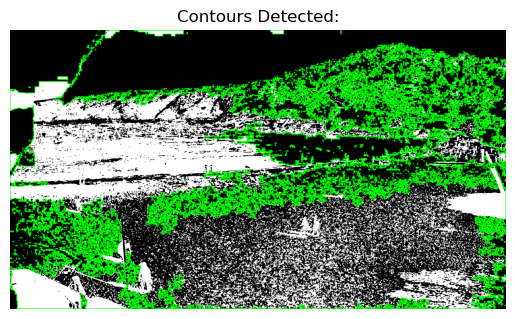

In [52]:
median_filter = cv2.cvtColor(median_filter, cv2.COLOR_RGB2GRAY)
contours, _ = cv2.findContours(median_filter, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = cv2.cvtColor(median_filter, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title(f"Contours Detected:")
plt.axis('off')
plt.show()